# Cross-Validation of `randomForest` model

Make a k-fold cross-validation using natural years. _Leave-one-(natural year)-out_

In [1]:
# Load packages
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))
suppressMessages(library(gridExtra))

suppressMessages(library(openair))

suppressMessages(library(caret))
suppressMessages(library(BBmisc))

In [2]:
suppressMessages(library(doMC))
registerDoMC(cores=12)

In [3]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [4]:
# Working directory
setwd("~/Repositories/AirQualityCOVID")

## Representative sample 

In [5]:
sites.lv <- c("es1580a")
variable.lv <- c("no2")

## DataFrame Creation

In [6]:
# Create dataSet
load("data/data_AQ.rda")
load("data/meteorology.rda")

aq <- data_AQ %>%
            filter(site %in% sites.lv,
                   variable %in% variable.lv
                  ) %>%
            timeAverage(avg.time = "day", type=c("site", "variable"))
aq$date <- as_date(aq$date)

mto <- data_Mto %>%
            filter(site %in% sites.lv)

data.df <- merge(aq, mto,
              by = c("date", "site"), all.x=T) %>%
        drop_na() %>%
        mutate_if(is.factor, as.character) %>%
        select(-date_end, -process, -summary, -validity)

rm(data_AQ)
rm(data_Mto)

## PreProcess

In [7]:
deseason <- function(cl) {
    # Remove seasonal component of the additive time serie.
    #     This function is called below by an apply
    
    dcomp <- decompose(ts(cl, frequency = 365))

    cl - dcomp$seasonal
}

scale.df <- function(df, omit.cl) {
    # Scale dataframe ignoring no numeric columns (omit.cl)
    
    split.df <- df[, -omit.cl]
    
    split.df <- scale(split.df)
    
    cbind(df[, omit.cl],
          apply(split.df, 2, function(cl) {cl + abs(min(cl))}))
}

range.df <- function(df, omit.cl) {
    # Scale dataframe ignoring no numeric columns (omit.cl)
    
    split.df <- df[, -omit.cl]
    
    split.df <- normalize(split.df, method = "range", range = c(0, 1), margin = 1)
    
    cbind(df[, omit.cl],
          split.df
          #apply(split.df, 2, function(cl) {range(cl) + abs(min(cl))})
         )
}

In [8]:
std.filter <- function(df, numSTD, omit.cl) {
    split.df <- df[, -omit.cl]
    
    for (cl in names(split.df)) {
        mn <- mean(split.df[, cl], na.rm=TRUE)
        std <- sd(split.df[, cl], na.rm=TRUE)

        split.df[which(split.df[, cl] < mn-numSTD*std), cl] <- NaN
        split.df[which(split.df[, cl] > mn+numSTD*std), cl] <- NaN
    }
    
    cbind(df[, omit.cl], split.df)
}

## Cross-Validation

In [9]:
leave.one.year.out <- function(yr, data, omit.cl) { 
    # Do k-iteration of k-fold cv by pop yr data for test 
    #     and the rest for training
    # @params: omit.cl: columns to omit in the regression
    
    test <- which(year(data$date) == yr)
    train <- which(year(data$date) != yr)

    if(length(test) == 0) {
        return()
    } 
    if (length(train) == 0) {
        return()
    }
    
    model <- train(value ~., 
                   data=data[, -omit.cl], subset=train,
                   method="rf", ntree=50, 
                   allowParallel = TRUE
                  )

    y.th <- predict(model, newdata=data[test,])
    
    plt <- ggplot() + 
        geom_line(aes(x=1:length(y.th), y=y.th), color="blue") +
        geom_line(aes(x=1:length(test), y=data[test, "value"]), color="red")
    
    data.frame("bias"=mean(y.th) / mean(data[test,]$value),
               "var.ratio"=var(y.th) / var(data[test,]$value),
               "cor"=cor(y.th, data[test,]$value, method = "pearson")
              )
}

In [10]:
no.num.cl <- 1:3 # no numeric columns 

if (sum(!is.na(data.df$date)) > (365*2)) {
    # if there is enough data (more than 2 years), deseasonalized
    ds.dat <- cbind(data.df[, no.num.cl],
                 apply(data.df[, -no.num.cl], 2, deseason))
} else { next }

ds.dat <- range.df(ds.dat, no.num.cl)# %>%
ds.dat <- std.filter(ds.dat, 3, no.num.cl) %>%
            drop_na()

train <- which(ds.dat$date < ymd("2020-01-01"))
test <- which(ds.dat$date > ymd("2020-01-01"))

model <- train(value ~., 
               data=ds.dat[, -no.num.cl], subset=train,
               method="rf", ntree=50, 
               allowParallel = TRUE
              )

y.th <- predict(model, newdata=ds.dat[test,])

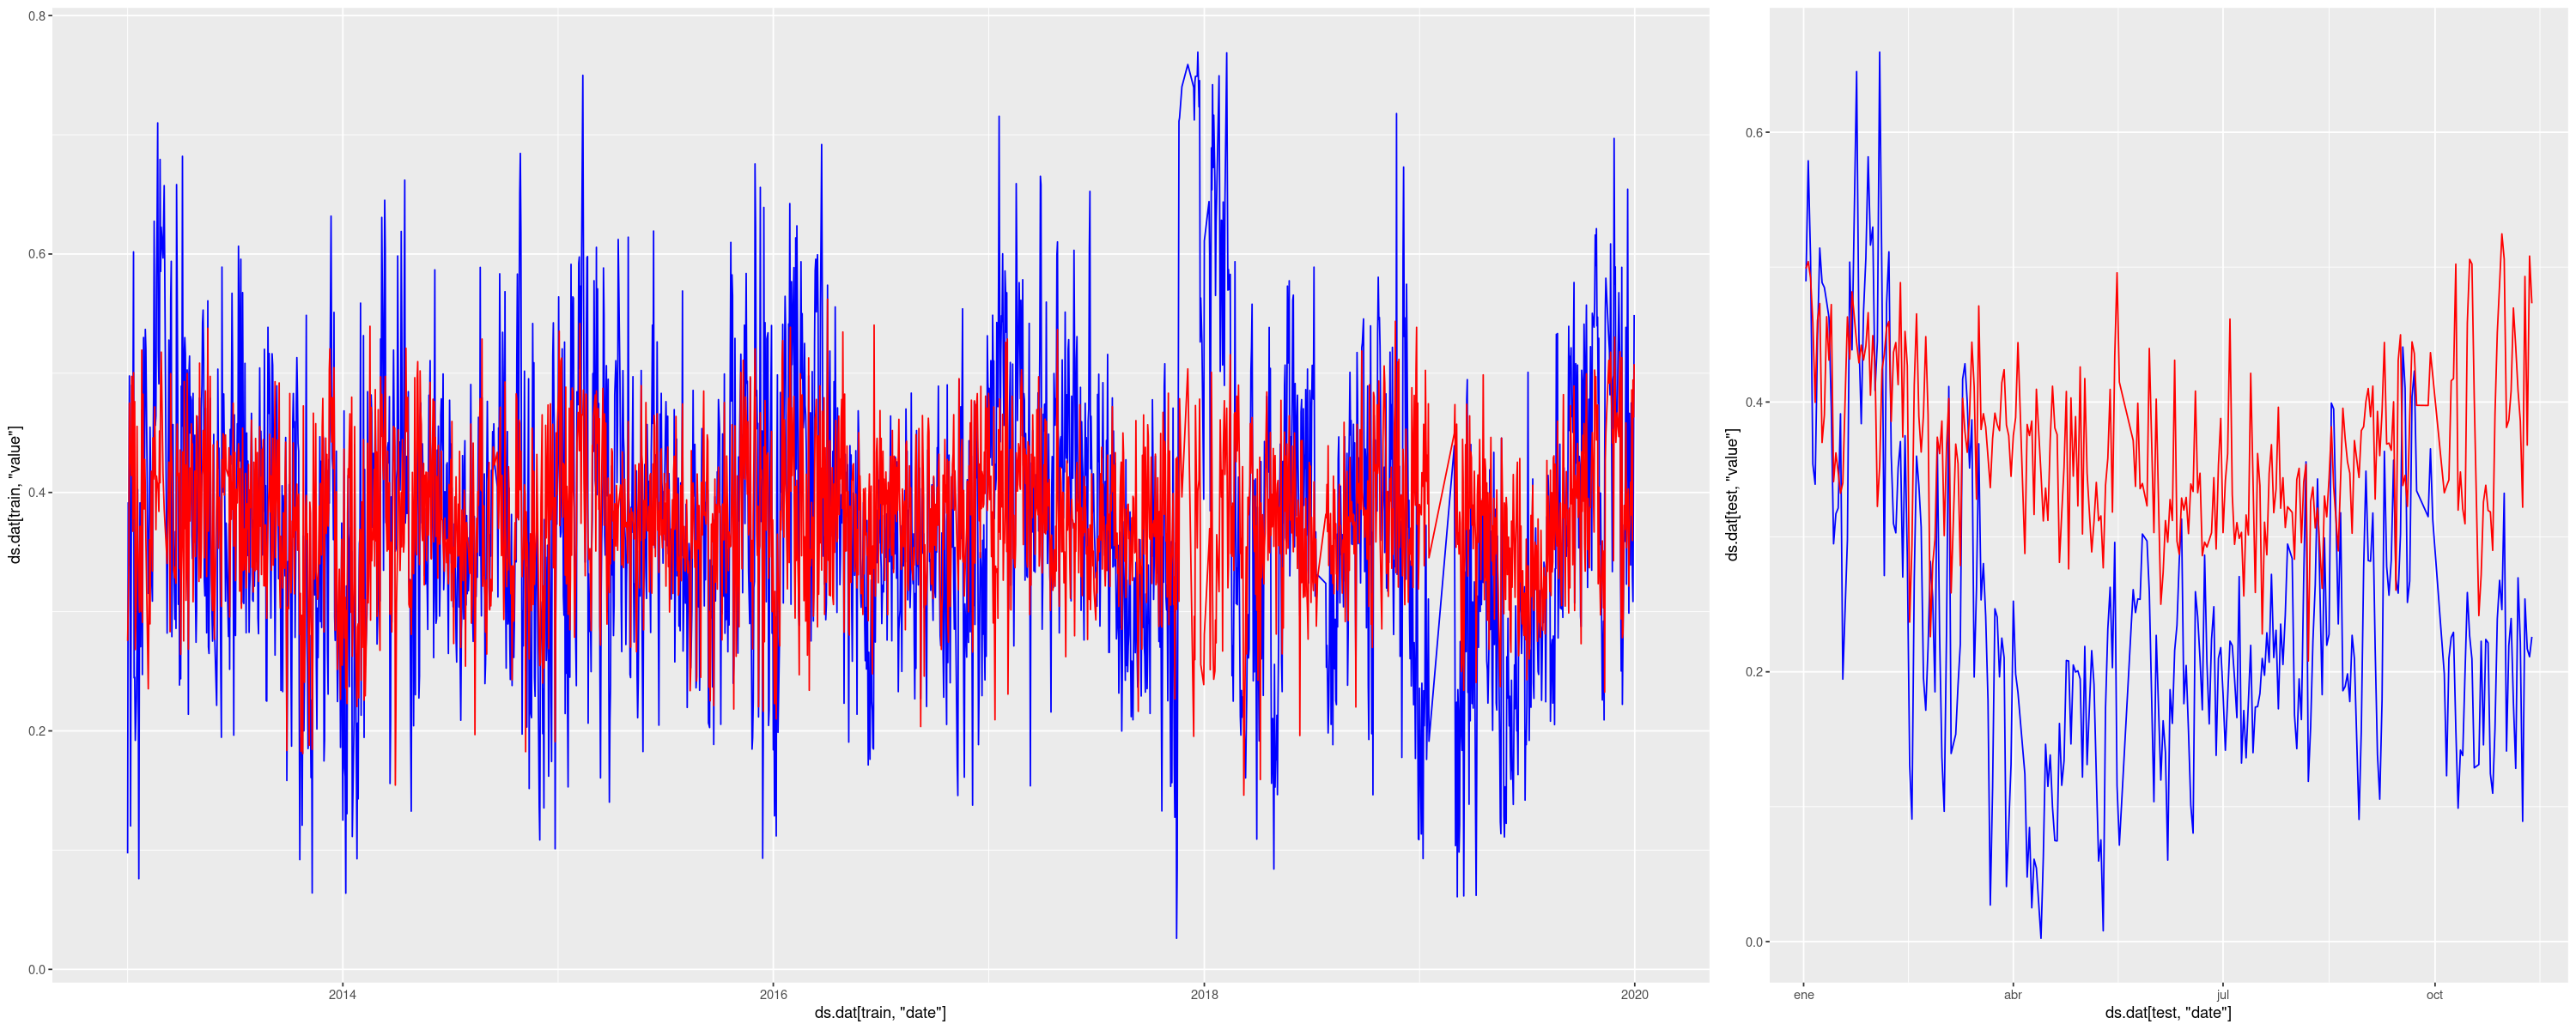

In [11]:
to.predict <- ggplot() +
                geom_line(aes(x=ds.dat[test, "date"], y=ds.dat[test, "value"]), color="blue") +
                geom_line(aes(x=ds.dat[test, "date"], y=y.th), color="red")

from.model <- ggplot() +
                geom_line(aes(x=ds.dat[train, "date"], y=ds.dat[train, "value"]), color="blue") +
                geom_line(aes(x=ds.dat[train, "date"], y=model$finalModel$predicted), color="red")

grid.arrange(from.model, to.predict, nrow = 1, widths = c(2, 1))